In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from plotnine import *
from pathlib import Path
from tqdm import tqdm
import seaborn as sns
import numpy as np
from datetime import datetime

data_folder = Path('../data') 
figures_folder = Path('../figures')
OCOD_history_path = data_folder / 'ocod_history_processed' 

list_of_files = list(OCOD_history_path.iterdir())



brexit_date = pd.to_datetime('2016-06-23')  # Brexit date
covid_date = pd.to_datetime('2020-03-23')   # First UK lockdown
ukraine_war_date = pd.to_datetime('2022-02-24')  # Start of Russia-Ukraine war

In [2]:
target_file = list_of_files[0]

target_year = pd.read_parquet(target_file)

In [3]:
def add_file_metadata(df, filename_stem):
    """Helper function to add filename and date columns to a dataframe"""
    df = df.copy()
    df['filename'] = filename_stem
    
    # Parse date once from filename
    parts = filename_stem.split('_')
    date_str = f"{parts[-2]}-{parts[-1]}-01"
    df['date'] = pd.to_datetime(date_str)
    
    return df

# Initialize lists
total_residential_df = []
total_per_region_df = []
total_incorp_df = []
total_resi_lad_df = []

for target_file in tqdm(list_of_files):
    target_year = pd.read_parquet(target_file)
    filename_stem = target_file.stem
    
    # Filter residential data once
    residential_data = target_year.loc[target_year['class2'] == 'residential']
    
    # Generate all required groupings
    groupings = {
        'total_residential': residential_data.groupby('nested_title').size().reset_index().rename(columns={0: 'counts'}),
        'total_resi_lad': residential_data.groupby(['nested_title', 'lad11cd']).size().reset_index().rename(columns={0: 'counts'}),
        'total_per_region': target_year.groupby(['region', 'class2']).size().reset_index().rename(columns={0: 'counts'}),
        'total_incorp': target_year.groupby('country_incorporated').size().reset_index().rename(columns={0: 'counts'})
    }
    
    # Add metadata and append to respective lists
    total_residential_df.append(add_file_metadata(groupings['total_residential'], filename_stem))
    total_resi_lad_df.append(add_file_metadata(groupings['total_resi_lad'], filename_stem))
    total_per_region_df.append(add_file_metadata(groupings['total_per_region'], filename_stem))
    total_incorp_df.append(add_file_metadata(groupings['total_incorp'], filename_stem))

# Concatenate all dataframes
total_residential_df = pd.concat(total_residential_df, ignore_index=True)
total_per_region_df = pd.concat(total_per_region_df, ignore_index=True)
total_incorp_df = pd.concat(total_incorp_df, ignore_index=True)
total_resi_lad_df = pd.concat(total_resi_lad_df, ignore_index=True) 

 10%|█         | 10/99 [00:02<00:21,  4.11it/s]

100%|██████████| 99/99 [00:24<00:00,  4.12it/s]


/tmp/ipykernel_2036/2345036112.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/total_properties.png


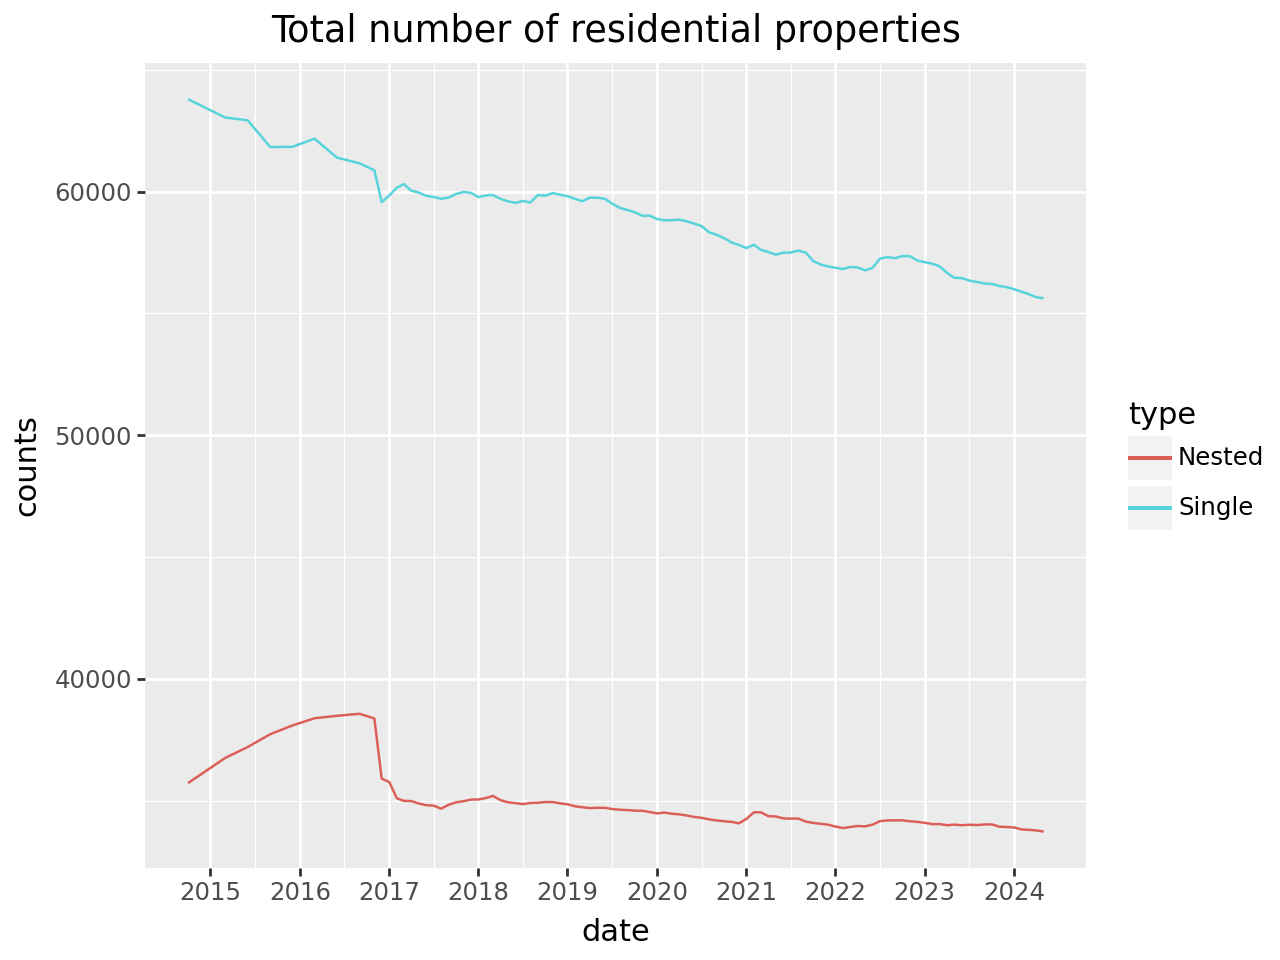

In [4]:

total_residential_df['type'] = np.where(total_residential_df['nested_title'], 'Nested', 'Single')

p = ggplot(total_residential_df, aes(x = 'date', 
y = 'counts', 
color = 'type') )+ geom_line() + labs(
    title = "Total number of residential properties") +   scale_x_date(
     breaks=pd.date_range(start=total_residential_df['date'].min(), end=total_residential_df['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = figures_folder /'total_properties.png')

p

/tmp/ipykernel_2036/414228278.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/properties_by_region.png


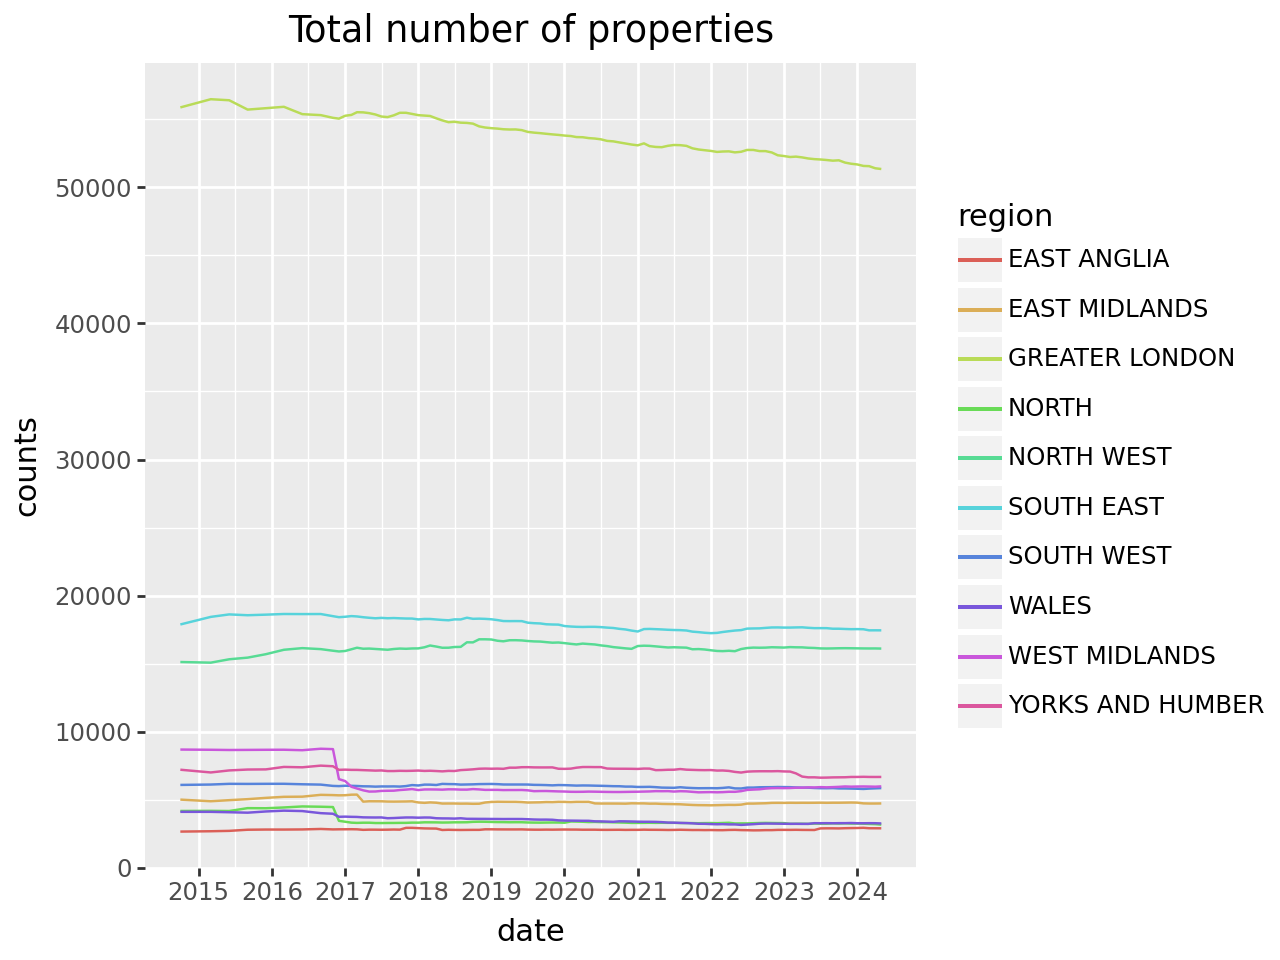

In [5]:

p = ggplot(total_per_region_df.groupby(['region', 'date'])['counts'].sum().reset_index(), aes(x='date', y='counts', color='region')) + \
    geom_line() + \
    labs(title="Total number of properties") + \
    scale_x_date(
        breaks=pd.date_range(start=total_residential_df['date'].min(), end=total_residential_df['date'].max(), freq='Y'),
        date_labels='%Y'
    ) 

p.save(filename = figures_folder /'properties_by_region.png')

p

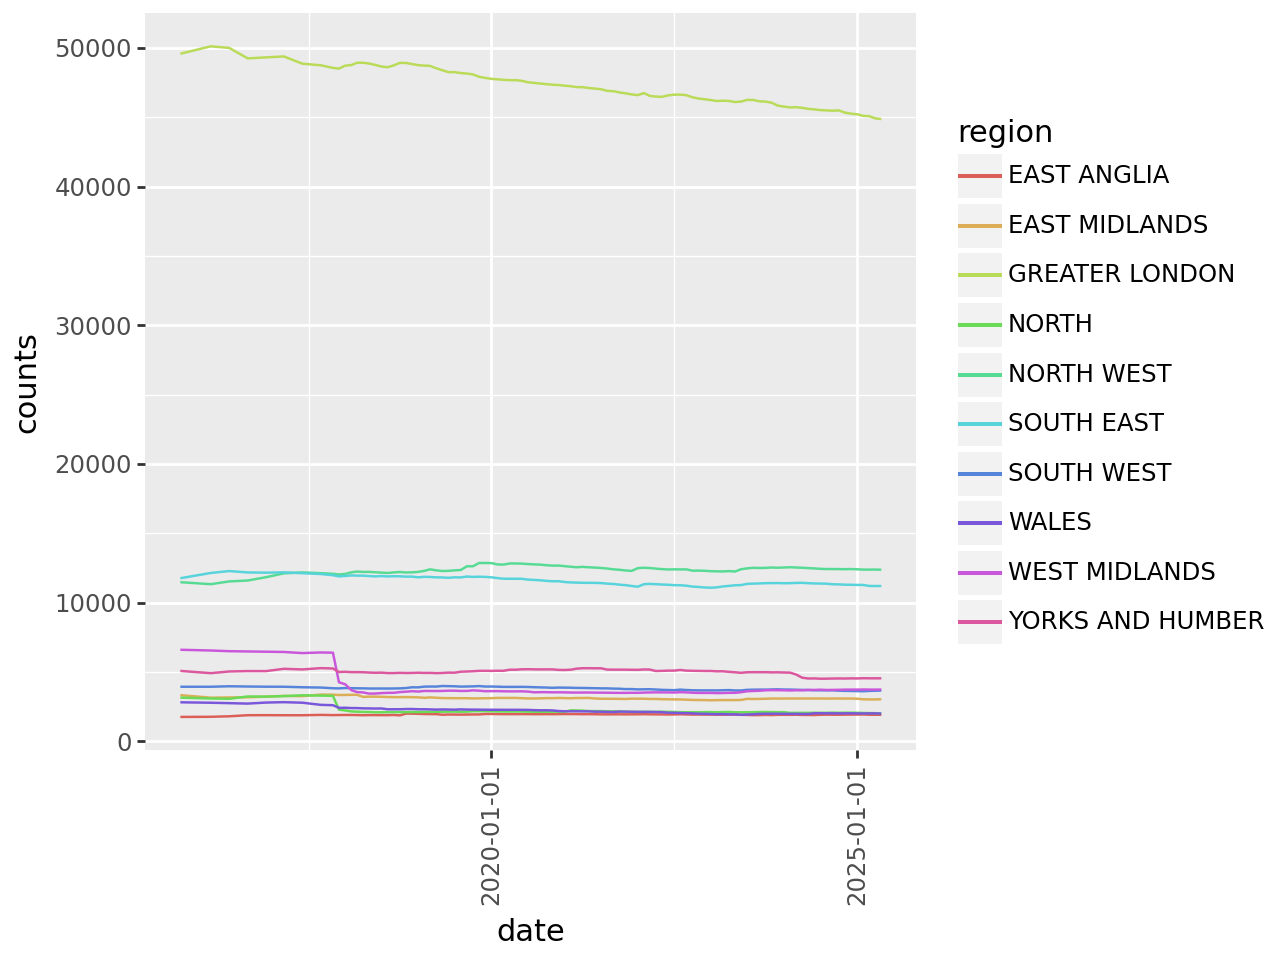

In [6]:
p = ggplot(total_per_region_df.loc[total_per_region_df['class2']=='residential'], aes( x = 'date', y = 'counts', colour = 'region')) + geom_line() + \
         theme(
        axis_text_x=element_text(angle=90),
    )


p

/tmp/ipykernel_2036/2219874210.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/properties_by_class.png


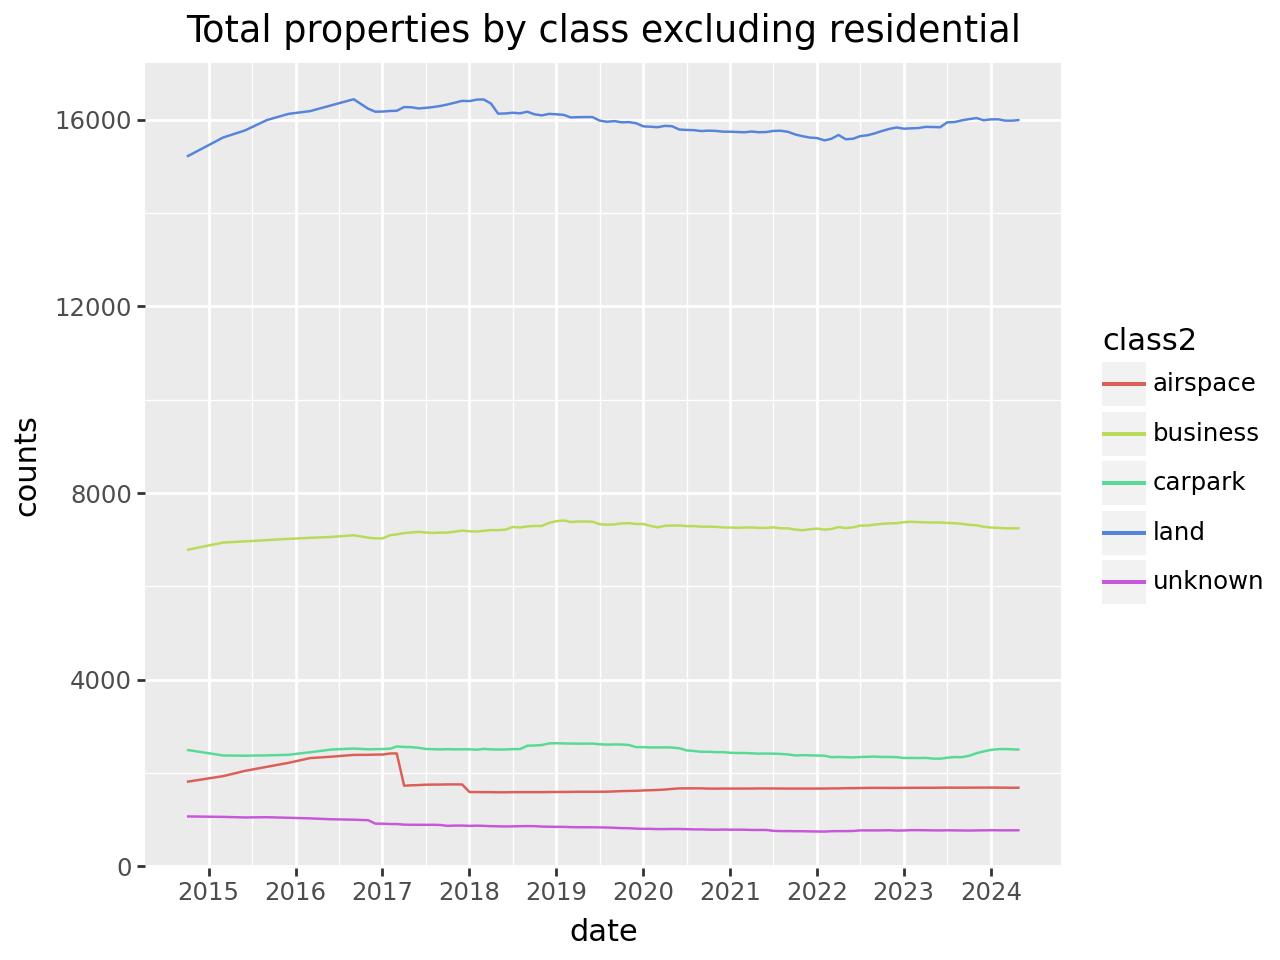

In [7]:
total_per_class_df = total_per_region_df.groupby(['class2', 'date'])['counts'].sum().reset_index()

p = ggplot(total_per_class_df.loc[total_per_class_df['class2']!='residential'], aes(x = 'date', 
y = 'counts', 
color = 'class2') )+ geom_line() + labs(
    title = "Total properties by class excluding residential") +   scale_x_date(
     breaks=pd.date_range(start=total_residential_df['date'].min(), end=total_residential_df['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 )

p.save(filename = figures_folder /'properties_by_class.png')

p

In [70]:
total_incorp_df['country_incorporated'] = total_incorp_df['country_incorporated'].str.replace("BRITISH VIRGIN ISLANDS", "BVI")

# Step 1: Calculate total counts per country across all years
country_totals = total_incorp_df.groupby('country_incorporated')['counts'].mean()

# Step 2: Get the top 10 countries
top_10_countries = country_totals.nlargest(20).index

# Step 3: Filter the original dataframe to only include top 10 countries
filtered_df = total_incorp_df[total_incorp_df['country_incorporated'].isin(top_10_countries)]

print("Top 10 countries by total counts:")
print(country_totals.nlargest(20))

Top 10 countries by total counts:
country_incorporated
JERSEY              27341.353535
BVI                 26124.949495
GUERNSEY            19601.242424
ISLE OF MAN         13120.525253
GIBRALTAR            3683.525253
LUXEMBOURG           3043.131313
SINGAPORE            2084.929293
IRELAND              1962.414141
HONG KONG            1859.090909
PANAMA               1830.333333
CAYMAN ISLANDS       1684.171717
SEYCHELLES           1596.939394
NETHERLANDS          1557.737374
CYPRUS               1408.171717
BAHAMAS              1380.626263
MAURITIUS            1087.818182
GERMANY               909.616162
AUSTRALIA             792.727273
BERMUDA               668.939394
DELAWARE, U.S.A.      668.838384
Name: counts, dtype: float64


In [69]:
total_incorp_df

,country_incorporated,counts,filename,date
0,00002065,4,OCOD_FULL_2015_10,2015-10-01
1,0003280,1,OCOD_FULL_2015_10,2015-10-01
2,02127156,1,OCOD_FULL_2015_10,2015-10-01
3,02366665,1,OCOD_FULL_2015_10,2015-10-01
4,05986778,1,OCOD_FULL_2015_10,2015-10-01
...,...,...,...,...
21390,"WASHINGTON, U.S.A.",9,OCOD_FULL_2025_05,2025-05-01
21391,WESTERN SAMOA,2,OCOD_FULL_2025_05,2025-05-01
21392,"WISCONSIN, U.S.A.",4,OCOD_FULL_2025_05,2025-05-01
21393,"WYOMING, U.S.A.",23,OCOD_FULL_2025_05,2025-05-01


/tmp/ipykernel_2036/2382936509.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6.4 x 4.8 in image.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../figures/properties_by_incorporation.png


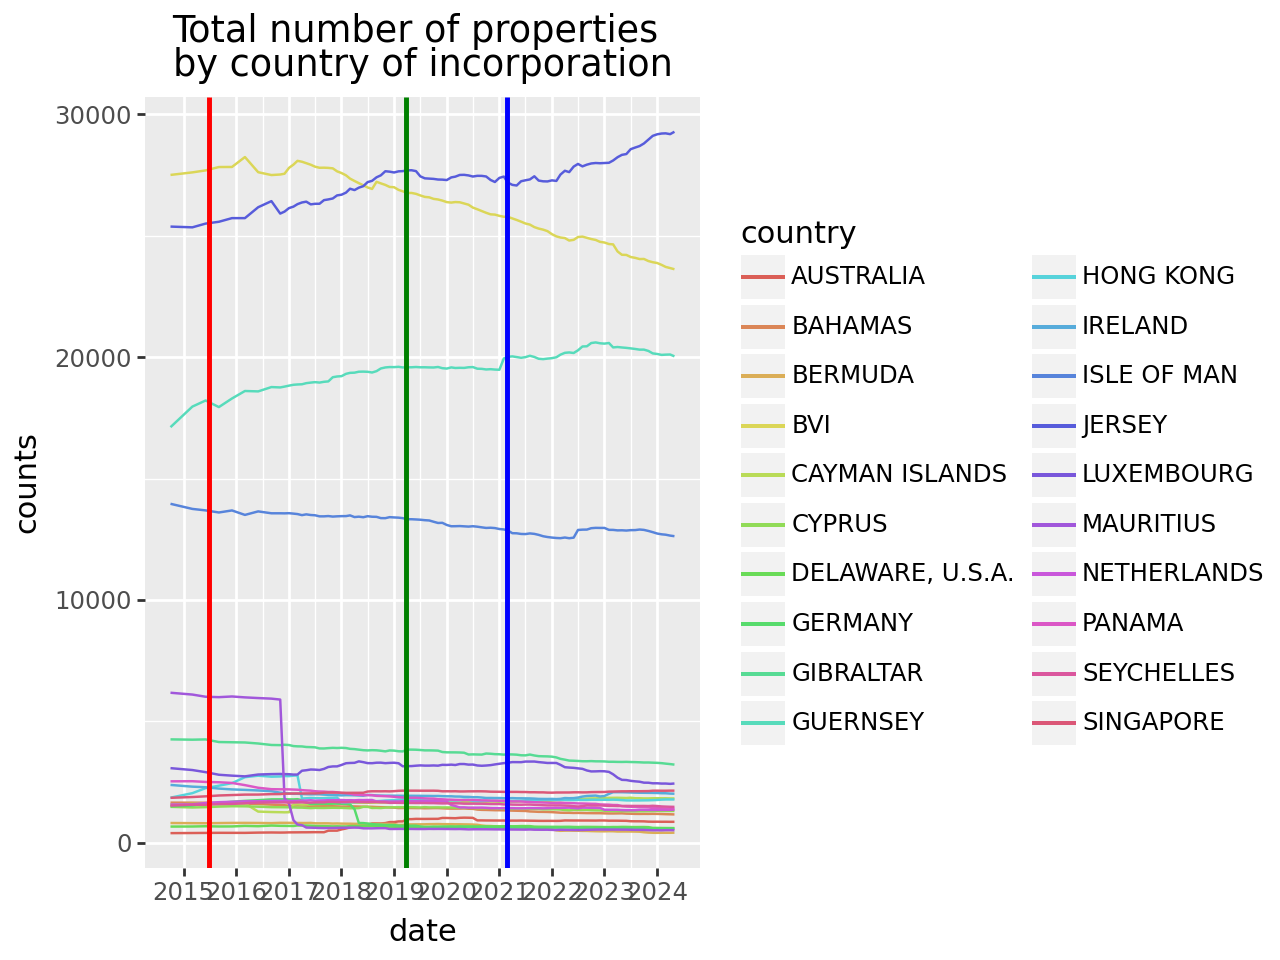

In [9]:
p = ggplot(filtered_df, aes(x = 'date', 
y = 'counts', 
color = 'country_incorporated') )+ geom_line() + labs(
    title = "Total number of properties\nby country of incorporation",
    ) +   scale_x_date(
     breaks=pd.date_range(start=filtered_df['date'].min(), end=filtered_df['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 ) + \
  guides(color = guide_legend(title = "country")) +\
    geom_vline(xintercept=brexit_date, color='red',  size=1) + \
    geom_vline(xintercept=covid_date, color='green', size=1) + \
    geom_vline(xintercept=ukraine_war_date, color='blue', size=1)

p.save(filename = figures_folder /'properties_by_incorporation.png')

p


In [73]:
test = total_incorp_df.copy()

test['diff'] = (test['counts'] - test.groupby('country_incorporated')['counts'].shift())/test.groupby('country_incorporated')['counts'].shift()

country_totals = test.groupby('country_incorporated')['diff'].mean()

# Step 2: Get the top 10 countries
top_10_countries = country_totals.nlargest(20).index

print(country_totals.nlargest(20))

country_incorporated
NORTH MACEDONIA      0.214286
CHILE                0.083844
MICHIGAN, U.S.A.     0.074063
ARMENIA              0.050000
QATAR                0.030536
HUNGARY              0.026531
SERBIA               0.023946
ABU DHABI            0.022495
SLOVAKIA             0.021599
KENYA                0.021429
REPUBLIC OF KOREA    0.021113
MACAO                0.020139
CZECH REPUBLIC       0.019797
FLORIDA, U.S.A.      0.019702
VANUATU              0.018950
LIBYA                0.017007
URUGUAY              0.017007
GEORGIA              0.016497
COLOMBIA             0.016304
ARIZONA, U.S.A.      0.015306
Name: diff, dtype: float64


/tmp/ipykernel_2036/3280645050.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.


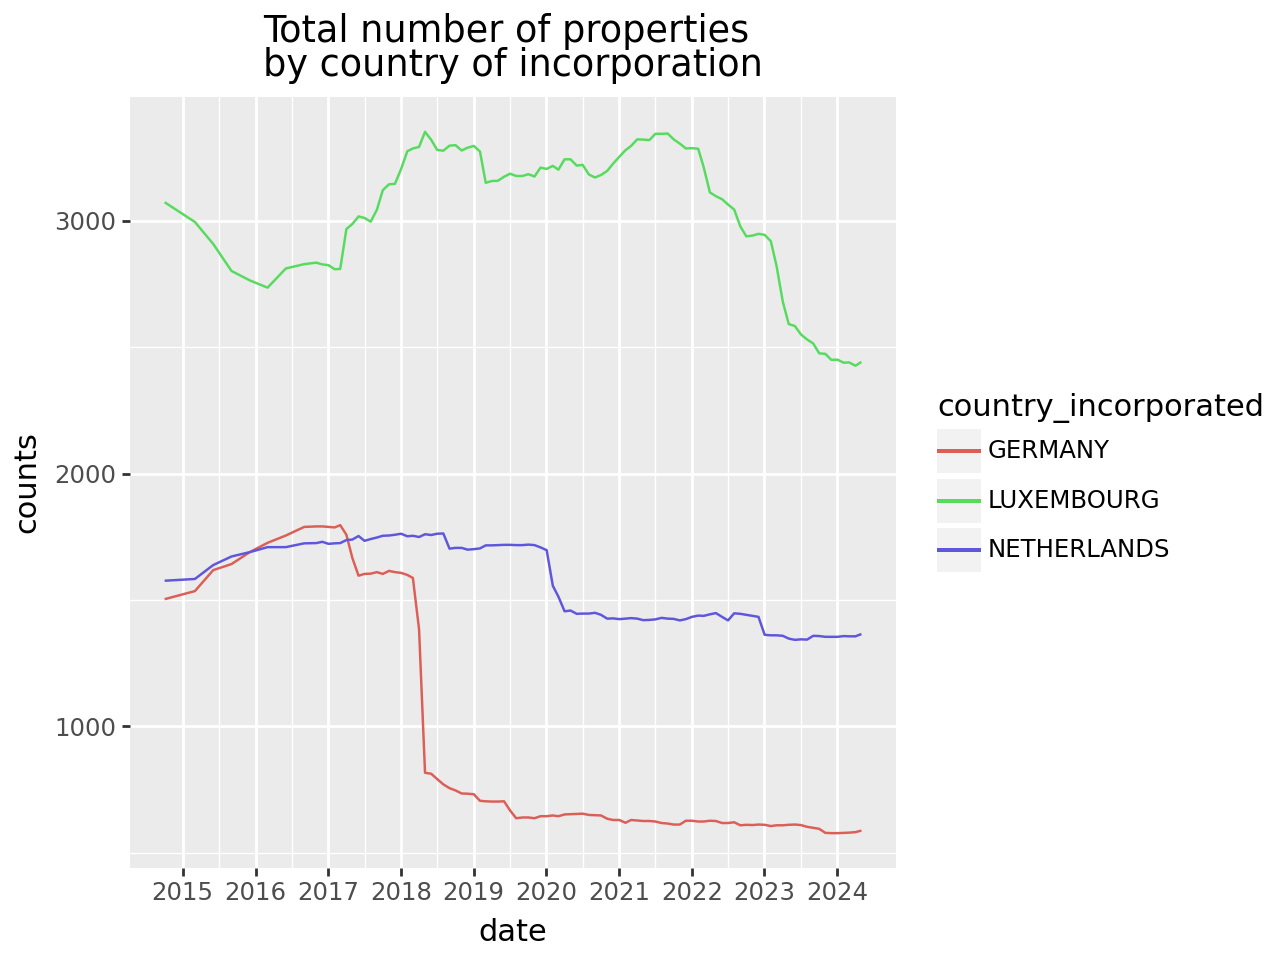

In [67]:
p = ggplot(test[test['country_incorporated'].isin(['LUXEMBOURG', 'NETHERLANDS', 'GERMANY'])], aes(x = 'date', 
y = 'counts', 
color = 'country_incorporated') )+ geom_line() + labs(
    title = "Total number of properties\nby country of incorporation",
    ) +   scale_x_date(
     breaks=pd.date_range(start=test['date'].min(), end=test['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 ) 

p

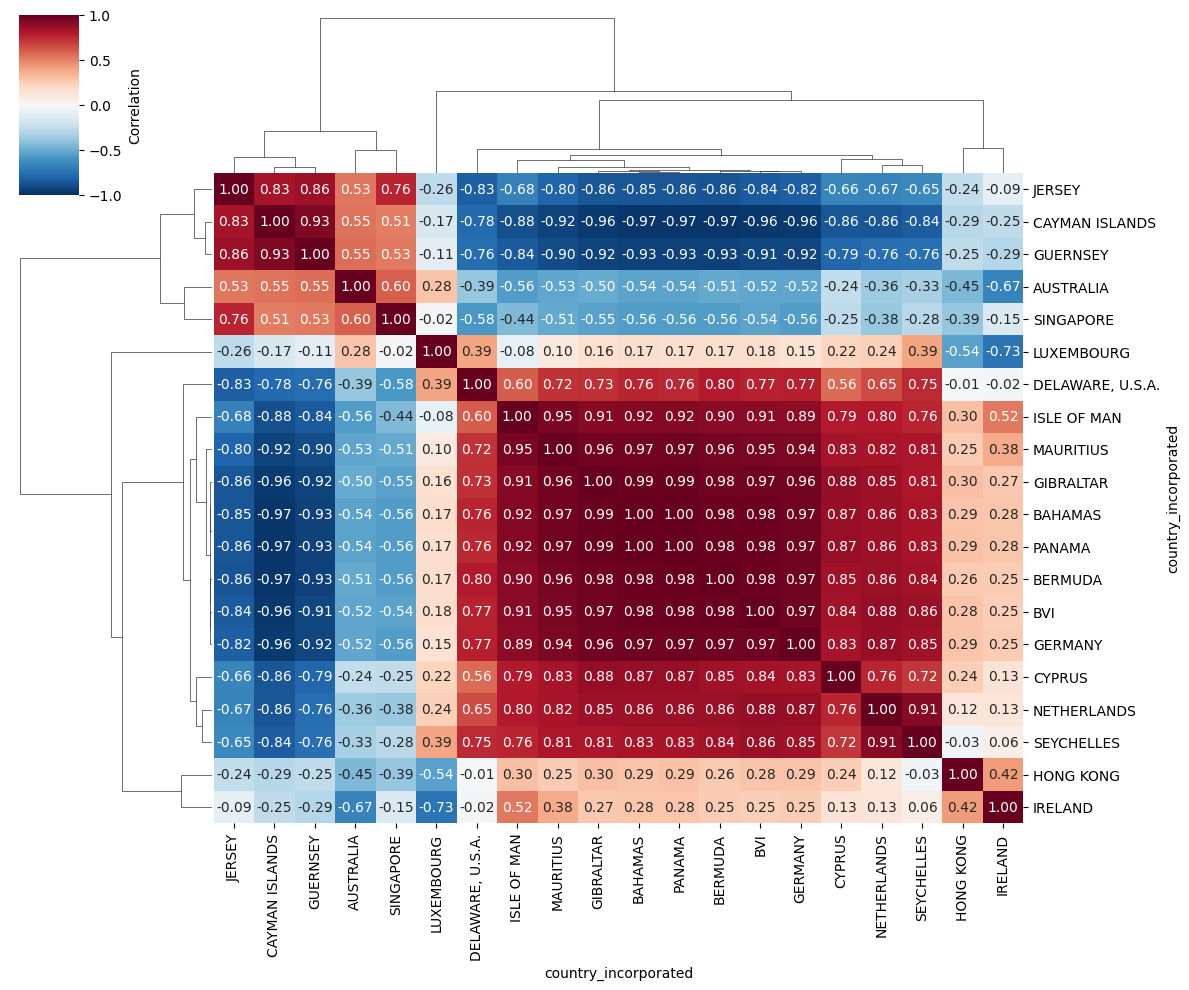

In [12]:
sns.clustermap(

    data=filtered_df.pivot(index='date', columns='country_incorporated', values='counts').corr(method = 'spearman'),
    
    # Clustering options
    method='average',        # linkage method: 'single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward'
    metric='euclidean',      # distance metric
    
    # Appearance options
    cmap='RdBu_r',          # colormap
    center=0,               # center point for colormap
    vmin=-1, vmax=1,        # value range for correlation

    # Size and layout
    figsize=(12, 10),
    
    # Annotations
    annot=True,             # show correlation values
    fmt='.2f',              # format for annotations
    # Dendrogram options
    row_cluster=True,       # cluster rows
    col_cluster=True,       # cluster columns

    # Color bar
    cbar_kws={'label': 'Correlation'}
)
plt.savefig(figures_folder /'incorporation_corr.png')
plt.show()

In [13]:
df_sorted_all = total_resi_lad_df.groupby(['lad11cd', 'date'])['counts'].sum().reset_index()
df_sorted_all = df_sorted_all.sort_values(['lad11cd', 'date'])
df_sorted_all['counts_diff'] = df_sorted_all.groupby(['lad11cd'])['counts'].diff()
df_sorted_all['nested_title'] = 'all'


df_sorted = total_resi_lad_df.sort_values(['lad11cd', 'date'])

# Calculate the difference in counts between consecutive dates for each LAD11cd
df_sorted['counts_diff'] = df_sorted.groupby(['lad11cd','nested_title'])['counts'].diff()


df_sorted['nested_title'] = np.where(df_sorted['nested_title'], 'nested', 'single')

df_sorted = pd.concat([df_sorted, df_sorted_all], ignore_index = True)

df_diff_change = df_sorted.groupby(['nested_title', 'lad11cd' ])['counts_diff'].mean().reset_index()
df_diff_change['total_mean_change'] = df_diff_change['counts_diff'] * total_resi_lad_df['date'].nunique()

df_diff_change.sort_values('total_mean_change')

,nested_title,lad11cd,counts_diff,total_mean_change
295,all,E09000033,-36.561224,-3619.561224
925,single,E09000033,-30.938776,-3062.938776
282,all,E09000020,-21.704082,-2148.704082
912,single,E09000020,-15.102041,-1495.102041
595,nested,E09000020,-6.602041,-653.602041
...,...,...,...,...
292,all,E09000030,3.816327,377.816327
290,all,E09000028,4.357143,431.357143
920,single,E09000028,4.479592,443.479592
551,nested,E08000012,4.877551,482.877551


/tmp/ipykernel_2036/3524276484.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


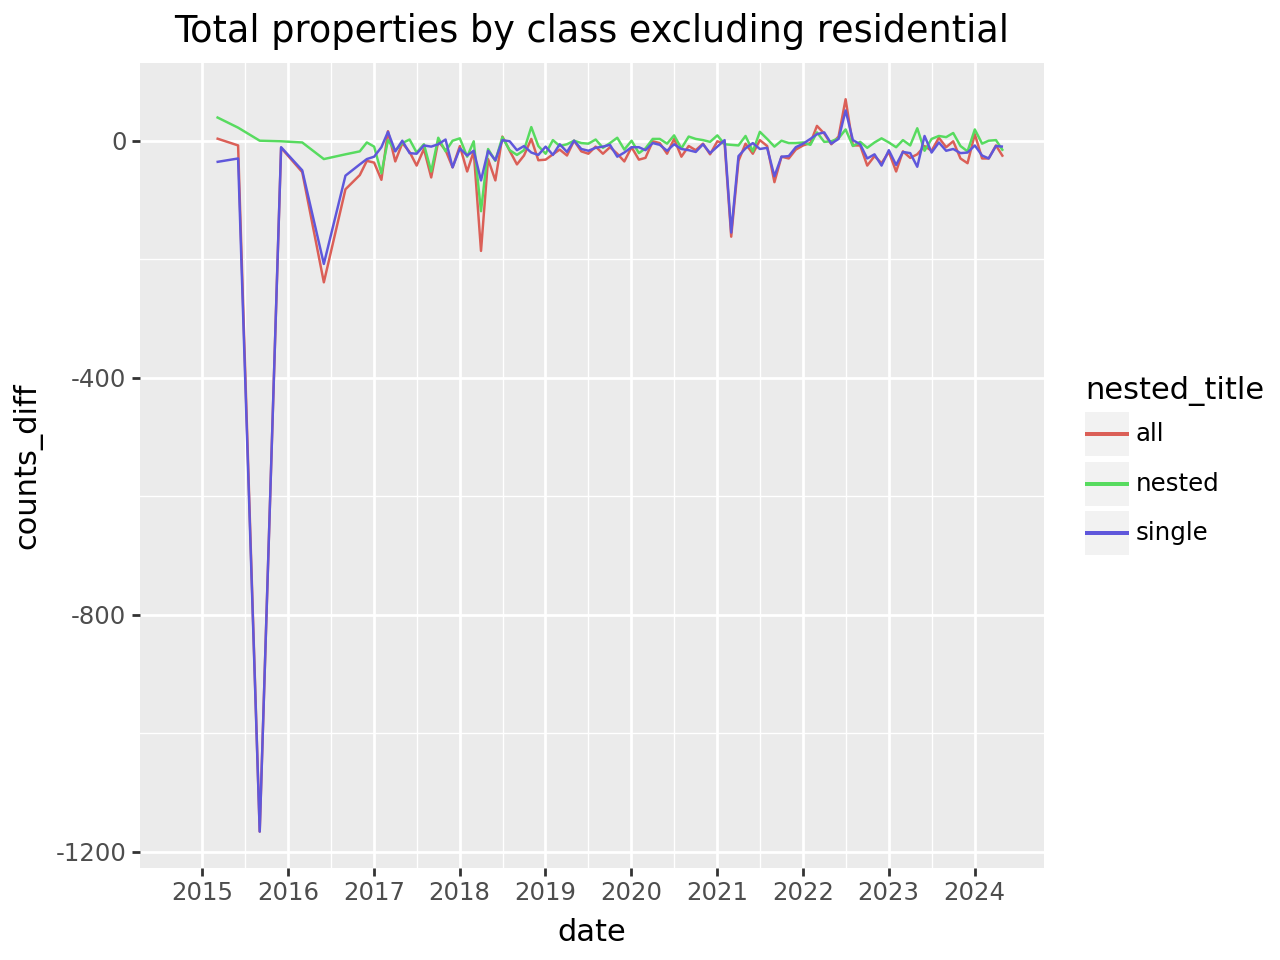

In [14]:
ggplot( df_sorted.loc[df_sorted['lad11cd']=='E09000033'],
aes(x = 'date', y = 'counts_diff', color = 'nested_title')) + geom_line() + labs(
    title = "Total properties by class excluding residential") +   scale_x_date(
     breaks=pd.date_range(start=total_residential_df['date'].min(), end=total_residential_df['date'].max(), freq='Y'),
     date_labels='%Y'  # Format to show only year
 )

In [15]:
df_diff_change = df_sorted.groupby(['nested_title', 'lad11cd' ])['counts_diff'].mean().reset_index()
df_diff_change['total_mean_change'] = df_diff_change['counts_diff'] * total_resi_lad_df['date'].nunique()

df_diff_change.sort_values('total_mean_change')

,nested_title,lad11cd,counts_diff,total_mean_change
295,all,E09000033,-36.561224,-3619.561224
925,single,E09000033,-30.938776,-3062.938776
282,all,E09000020,-21.704082,-2148.704082
912,single,E09000020,-15.102041,-1495.102041
595,nested,E09000020,-6.602041,-653.602041
...,...,...,...,...
292,all,E09000030,3.816327,377.816327
290,all,E09000028,4.357143,431.357143
920,single,E09000028,4.479592,443.479592
551,nested,E08000012,4.877551,482.877551


In [16]:
import requests
import os

def download_shapefile(url, local_path):
    """
    Download shapefile from URL to specified local path
    """
    try:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        
        # Download the file
        response = requests.get(url, stream=True)
        response.raise_for_status()
        
        # Save to local file
        with open(local_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        
        print(f"File downloaded successfully to: {local_path}")
        return True
        
    except Exception as e:
        print(f"Error downloading file: {e}")
        return False

# Usage
url = 'https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/fdde56bfb32e498c92fda3873021d759/shapefile?layers=0'

# Specify your desired local path
local_path = Path('../data') / 'lad_shapefile.zip'

download_shapefile(url, local_path)

File downloaded successfully to: ../data/lad_shapefile.zip


True

In [17]:
# Helper function to calculate months between dates
def months_between(date1, date2):
    return (date2.year - date1.year) * 12 + (date2.month - date1.month)

# Process 'all' group
df_sorted_all = total_resi_lad_df.groupby(['lad11cd', 'date'])['counts'].sum().reset_index()
df_sorted_all = df_sorted_all.sort_values(['lad11cd', 'date'])
df_sorted_all['counts_diff'] = df_sorted_all.groupby(['lad11cd'])['counts'].diff()

# Calculate months between consecutive dates
df_sorted_all['prev_date'] = df_sorted_all.groupby(['lad11cd'])['date'].shift(1)
df_sorted_all['months_diff'] = df_sorted_all.apply(
    lambda row: months_between(row['prev_date'], row['date']) if pd.notna(row['prev_date']) else np.nan, 
    axis=1
)

# Calculate monthly change (divide by number of months)
df_sorted_all['monthly_change'] = df_sorted_all['counts_diff'] / df_sorted_all['months_diff']
df_sorted_all['nested_title'] = 'all'

# Process main dataframe
df_sorted = total_resi_lad_df.sort_values(['lad11cd', 'date'])

# Calculate the difference in counts between consecutive dates for each LAD11cd
df_sorted['counts_diff'] = df_sorted.groupby(['lad11cd','nested_title'])['counts'].diff()

# Calculate months between consecutive dates
df_sorted['prev_date'] = df_sorted.groupby(['lad11cd', 'nested_title'])['date'].shift(1)
df_sorted['months_diff'] = df_sorted.apply(
    lambda row: months_between(row['prev_date'], row['date']) if pd.notna(row['prev_date']) else np.nan, 
    axis=1
)

# Calculate monthly change (divide by number of months)
df_sorted['monthly_change'] = df_sorted['counts_diff'] / df_sorted['months_diff']

df_sorted['nested_title'] = np.where(df_sorted['nested_title'], 'nested', 'single')

# Use monthly_change instead of counts_diff for concatenation
df_sorted_all_final = df_sorted_all[['lad11cd', 'date', 'monthly_change', 'nested_title']]
df_sorted_final = df_sorted[['lad11cd', 'date', 'monthly_change', 'nested_title']]

df_sorted_combined = pd.concat([df_sorted_final, df_sorted_all_final], ignore_index=True)

# Calculate mean monthly change
df_diff_change = df_sorted_combined.groupby(['nested_title', 'lad11cd'])['monthly_change'].mean().reset_index()

# Calculate total months in dataset
min_date = total_resi_lad_df['date'].min()
max_date = total_resi_lad_df['date'].max()
total_months = months_between(min_date, max_date)

# Multiply by total months instead of unique dates
df_diff_change['total_mean_change'] = df_diff_change['monthly_change'] * total_months

df_diff_change.sort_values('total_mean_change')

,nested_title,lad11cd,monthly_change,total_mean_change
295,all,E09000033,-25.685714,-2953.857143
925,single,E09000033,-20.073469,-2308.448980
282,all,E09000020,-17.586395,-2022.435374
912,single,E09000020,-12.431633,-1429.637755
608,nested,E09000033,-5.612245,-645.408163
...,...,...,...,...
862,single,E08000006,3.470068,399.057823
290,all,E09000028,3.567687,410.284014
920,single,E09000028,3.852381,443.023810
551,nested,E08000012,4.059864,466.884354


In [18]:
import geopandas as gpd

# Read directly from the ZIP file
gdf = gpd.read_file("../data/lad_shapefile.zip")

In [20]:
temp = df_diff_change.copy()

temp['increase'] = (temp['total_mean_change']>0).astype(int)

temp.groupby('nested_title')['increase'].describe()

,count,mean,std,min,25%,50%,75%,max
nested_title,,,,,,,,
all,318.0,0.286164,0.452679,0.0,0.0,0.0,1.0,1.0
nested,312.0,0.394231,0.489470,0.0,0.0,0.0,1.0,1.0
single,318.0,0.232704,0.423221,0.0,0.0,0.0,0.0,1.0


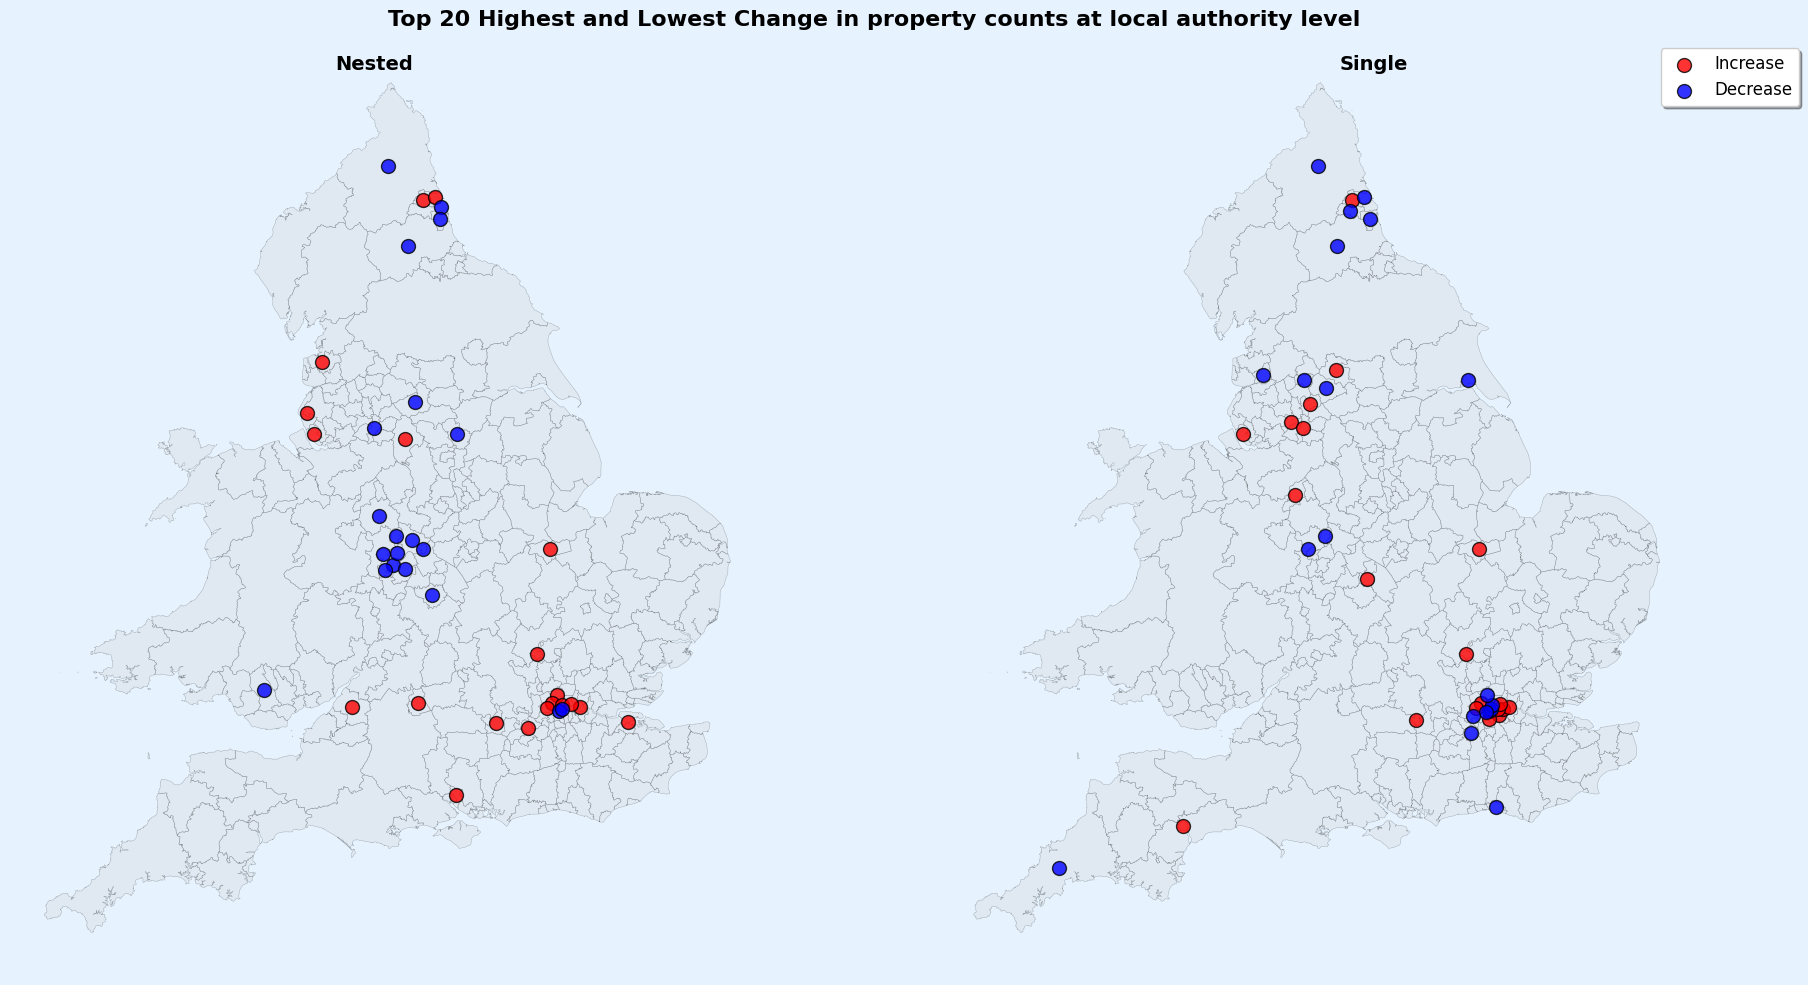

In [21]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Filter gdf to only include areas with LAD23CD containing "E" or "W" Remove silly isles for visual compactness
gdf_filtered = gdf[gdf['LAD25CD'].str.contains('E|W', na=False) & (gdf['LAD25CD']!='E06000053')]

# Create subplots with light blue background
fig, axes = plt.subplots(1, 2, figsize=(20, 10), facecolor='#E6F3FF')

# Categories to plot
categories = ['nested', 'single']

# Plot each category
for i, category in enumerate(categories):
    # Merge for each category
    gdf_temp = gdf_filtered.merge(df_diff_change.loc[df_diff_change['nested_title']==category], 
                                  left_on='LAD25CD', 
                                  right_on='lad11cd', 
                                  how='left')
    
    # Fill missing values with 0
    gdf_temp['total_mean_change'] = gdf_temp['total_mean_change'].fillna(0)
    
    # Apply transformation
    gdf_temp['total_mean_change'] = np.where(gdf_temp['total_mean_change'] < -500, -500, gdf_temp['total_mean_change'])
    
    # Set light blue background for axes
    axes[i].set_facecolor('#E6F3FF')
    
    # Plot base map with light gray fill and black borders
    gdf_filtered.plot(ax=axes[i], 
                      facecolor='lightgray', 
                      edgecolor='black', 
                      linewidth=0.3,
                      alpha=0.3)
    
    # Remove rows with NaN values for ranking
    gdf_temp_clean = gdf_temp.dropna(subset=['total_mean_change'])
    
    # Get top 10 highest values
    top_10_highest = gdf_temp_clean.nlargest(20, 'total_mean_change')
    
    # Get top 10 lowest values  
    top_10_lowest = gdf_temp_clean.nsmallest(20, 'total_mean_change')
    
    # Get centroids for point plotting
    top_10_highest_centroids = top_10_highest.geometry.centroid
    top_10_lowest_centroids = top_10_lowest.geometry.centroid
    
    # Plot highest values as red circles
    axes[i].scatter(top_10_highest_centroids.x, 
                    top_10_highest_centroids.y,
                    c='red', 
                    s=100, 
                    alpha=0.8,
                    edgecolor='black',
                    linewidth=1,
                    label='Increase',
                    zorder=5)
    
    # Plot lowest values as blue circles
    axes[i].scatter(top_10_lowest_centroids.x, 
                    top_10_lowest_centroids.y,
                    c='blue', 
                    s=100, 
                    alpha=0.8,
                    edgecolor='black',
                    linewidth=1,
                    label='Decrease',
                    zorder=5)
    
    # Add legend only to the second plot
    if i == 1:
        axes[i].legend(loc='upper right', 
                      bbox_to_anchor=(1.15, 1),
                      fontsize=12,
                      frameon=True,
                      fancybox=True,
                      shadow=True)
    
    # Turn off axis
    axes[i].set_axis_off()

# Add titles manually using fig.text for perfect alignment
fig.text(0.25, 0.92, 'Nested', fontsize=14, fontweight='bold', ha='center')
fig.text(0.75, 0.92, 'Single', fontsize=14, fontweight='bold', ha='center')

# Overall title
fig.suptitle('Top 20 Highest and Lowest Change in property counts at local authority level', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig(figures_folder /'change_maps.png')
plt.show()




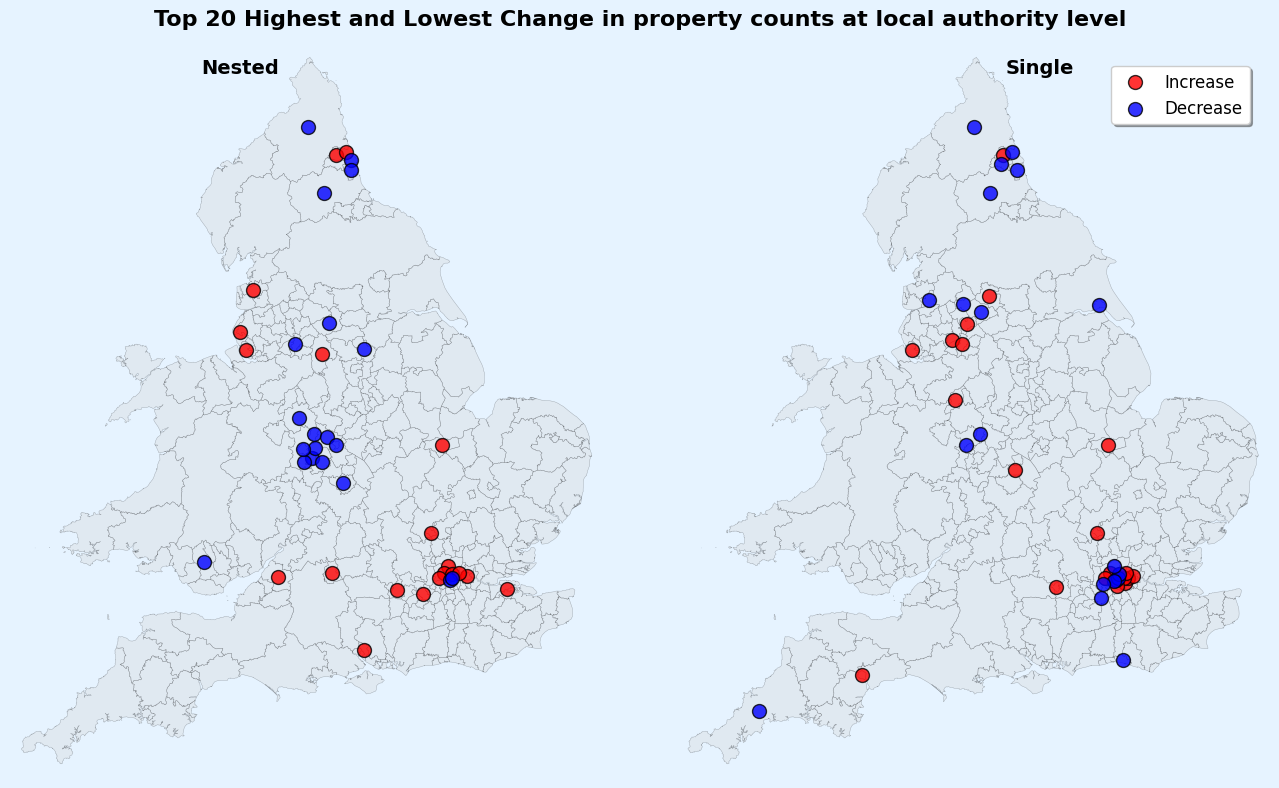

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Filter gdf to only include areas with LAD23CD containing "E" or "W" Remove silly isles for visual compactness
gdf_filtered = gdf[gdf['LAD25CD'].str.contains('E|W', na=False) & (gdf['LAD25CD']!='E06000053')]

# Create subplots with light blue background - reduced width
fig, axes = plt.subplots(1, 2, figsize=(16, 8), facecolor='#E6F3FF')

# Categories to plot
categories = ['nested', 'single']

# Get the bounds of the filtered data for consistent scaling
bounds = gdf_filtered.total_bounds
x_buffer = (bounds[2] - bounds[0]) * 0.02  # 2% buffer
y_buffer = (bounds[3] - bounds[1]) * 0.02  # 2% buffer

# Plot each category
for i, category in enumerate(categories):
    # Merge for each category
    gdf_temp = gdf_filtered.merge(df_diff_change.loc[df_diff_change['nested_title']==category], 
                                  left_on='LAD25CD', 
                                  right_on='lad11cd', 
                                  how='left')
    
    # Fill missing values with 0
    gdf_temp['total_mean_change'] = gdf_temp['total_mean_change'].fillna(0)
    
    # Apply transformation
    gdf_temp['total_mean_change'] = np.where(gdf_temp['total_mean_change'] < -500, -500, gdf_temp['total_mean_change'])
    
    # Set light blue background for axes
    axes[i].set_facecolor('#E6F3FF')
    
    # Plot base map with light gray fill and black borders
    gdf_filtered.plot(ax=axes[i], 
                      facecolor='lightgray', 
                      edgecolor='black', 
                      linewidth=0.3,
                      alpha=0.3)
    
    # Remove rows with NaN values for ranking
    gdf_temp_clean = gdf_temp.dropna(subset=['total_mean_change'])
    
    # Get top 10 highest values
    top_10_highest = gdf_temp_clean.nlargest(20, 'total_mean_change')
    
    # Get top 10 lowest values  
    top_10_lowest = gdf_temp_clean.nsmallest(20, 'total_mean_change')
    
    # Get centroids for point plotting
    top_10_highest_centroids = top_10_highest.geometry.centroid
    top_10_lowest_centroids = top_10_lowest.geometry.centroid
    
    # Plot highest values as red circles
    axes[i].scatter(top_10_highest_centroids.x, 
                    top_10_highest_centroids.y,
                    c='red', 
                    s=100, 
                    alpha=0.8,
                    edgecolor='black',
                    linewidth=1,
                    label='Increase',
                    zorder=5)
    
    # Plot lowest values as blue circles
    axes[i].scatter(top_10_lowest_centroids.x, 
                    top_10_lowest_centroids.y,
                    c='blue', 
                    s=100, 
                    alpha=0.8,
                    edgecolor='black',
                    linewidth=1,
                    label='Decrease',
                    zorder=5)
    
    # Set consistent axis limits with minimal buffer
    axes[i].set_xlim(bounds[0] - x_buffer, bounds[2] + x_buffer)
    axes[i].set_ylim(bounds[1] - y_buffer, bounds[3] + y_buffer)
    
    # Add legend only to the second plot
    if i == 1:
        axes[i].legend(loc='upper right', 
                      bbox_to_anchor=(0.98, 0.98),  # Adjusted to fit within plot
                      fontsize=12,
                      frameon=True,
                      fancybox=True,
                      shadow=True)
    
    # Turn off axis
    axes[i].set_axis_off()

# Adjust subplot spacing to reduce margins
plt.subplots_adjust(left=0.02, right=0.98, wspace=0.05)

# Add titles manually using fig.text for perfect alignment
fig.text(0.25, 0.9, 'Nested', fontsize=14, fontweight='bold', ha='center')
fig.text(0.75, 0.9, 'Single', fontsize=14, fontweight='bold', ha='center')

# Overall title
fig.suptitle('Top 20 Highest and Lowest Change in property counts at local authority level', 
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.savefig(figures_folder / 'change_maps.png', bbox_inches='tight', dpi=300)
plt.show()

In [23]:
gdf_filtered.merge(df_diff_change.loc[df_diff_change['nested_title']=='nested'], 
                                  left_on='LAD25CD', 
                                  right_on='lad11cd', 
                                  how='left')['total_mean_change'].describe()

count    310.000000
mean     -14.240692
std       82.509594
min     -645.408163
25%      -13.983844
50%       -3.520408
75%        7.823129
max      466.884354
Name: total_mean_change, dtype: float64

In [24]:
temp = gdf_filtered.merge(df_diff_change.loc[df_diff_change['nested_title']=='all'], 
                                  left_on='LAD25CD', 
                                  right_on='lad11cd', 
                                  how='left').sort_values('total_mean_change')

temp.loc[temp['total_mean_change'].notna(), ["LAD25NM", "total_mean_change"]].head(10)

,LAD25NM,total_mean_change
294,Westminster,-2953.857143
281,Kensington and Chelsea,-2022.435374
180,Cannock Chase,-563.382653
250,Sandwell,-475.959184
52,Northumberland,-452.802721
182,Lichfield,-448.265306
274,Hammersmith and Fulham,-311.438776
246,Sunderland,-299.195578
247,Birmingham,-295.714286
44,County Durham,-254.486395


# concentration

As we can see the majority of change is concentrated into a very small number of local authorities

In [25]:
temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']<0), ["LAD25NM", "total_mean_change"]].head(20)['total_mean_change'].sum()/ \
    temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']<0),'total_mean_change'].sum()

0.5972144406447097

In [26]:
temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']>0), ["LAD25NM", "total_mean_change"]].tail(20)['total_mean_change'].sum()/ \
    temp.loc[temp['total_mean_change'].notna() & (temp['total_mean_change']>0),'total_mean_change'].sum()

0.7607899007291041

In [27]:
import numpy as np
from scipy import stats

def bootstrap_ratio_test(ratios, n_bootstrap=1000, random_state=42):
    """
    Vectorized bootstrap test for whether mean ratio is significantly different from 1
    
    Args:
        ratios (array-like): Array of price ratios
        n_bootstrap (int): Number of bootstrap samples
        random_state (int): Random seed for reproducibility
    
    Returns:
        dict: Contains fractions above/below 1, mean_ratio, confidence intervals, and significance
    """
    ratios = np.array(ratios)
    n = len(ratios)
    
    if n < 2:
        return {
            'fraction_above_one': np.nan,
            'fraction_below_one': np.nan,
            'significantly_different': False,
            'mean_ratio': np.nan,
            'ci_lower': np.nan,
            'ci_upper': np.nan
        }
    
    np.random.seed(random_state)
    
    # Generate bootstrap samples - vectorized
    bootstrap_indices = np.random.choice(n, size=(n_bootstrap, n), replace=True)
    bootstrap_samples = ratios[bootstrap_indices]
    
    # Calculate means for all bootstrap samples at once
    bootstrap_means = np.mean(bootstrap_samples, axis=1)
    
    # Calculate results
    fraction_above_one = np.mean(bootstrap_means > 1.0)
    fraction_below_one = np.mean(bootstrap_means < 1.0)
    
    # Check if significantly different from 1 (two-tailed test at 0.05 level)
    significantly_different = (fraction_above_one > 0.975) or (fraction_below_one > 0.975)
    
    mean_ratio = np.mean(ratios)
    ci_lower = np.percentile(bootstrap_means, 2.5)
    ci_upper = np.percentile(bootstrap_means, 97.5)
    
    return {
        'fraction_above_one': fraction_above_one,
        'fraction_below_one': fraction_below_one,
        'significantly_different': significantly_different,
        'mean_ratio': mean_ratio,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

def create_mean_difference_by_groups(grouping_vars):
    """
    Calculate mean difference price (average trend) for each group
    
    Args:
        grouping_vars (list): List of column names to group by (e.g., ['localauthority'])
                             Cannot be None - grouping variables are required
    """
    if grouping_vars is None:
        raise ValueError("grouping_vars cannot be None. Please provide grouping variables.")
    
    ocod_path = Path('../data/ocod_history_processed')
    price_paid_path = Path('../data/price_paid_msoa_averages')

    # List to store monthly results
    monthly_results = []

    # Get all parquet files from ocod directory
    ocod_files = sorted(list(ocod_path.glob('*.parquet')))

    for ocod_file in tqdm(ocod_files):
        # Extract year and month from filename
        filename_parts = ocod_file.stem.split('_')
        year = int(filename_parts[-2])
        month = int(filename_parts[-1])
        
        # Create corresponding price_paid filename
        price_paid_file = price_paid_path / f'price_paid_{year}_{month:02d}.parquet'
        
        # Check if corresponding price_paid file exists
        if not price_paid_file.exists():
            continue
        
        try:
            # Read the data
            ocod_df = pd.read_parquet(ocod_file)
            price_paid_df = pd.read_parquet(price_paid_file)
            
            # Filter for residential properties
            ocod_residential = ocod_df.loc[ocod_df['class2']=='residential'].copy()
            
            # Skip if no residential properties
            if ocod_residential.empty:
                continue
            
            # Group and count by msoa11cd + grouping variables
            group_cols = ['msoa11cd'] + grouping_vars
            ocod_grouped = ocod_residential.groupby(group_cols).size().reset_index().rename(columns={0:'counts'})
            
            # Merge with price data
            df = price_paid_df.merge(ocod_grouped, on='msoa11cd')
            
            # Skip if no data after merge
            if df.empty:
                continue
            
            # Create date as first day of the month
            date = datetime(year, month, 1)
            
            # Group by grouping variables and calculate weighted/unweighted means
            # Use scalar for single grouping var, list for multiple to avoid tuple issues
            group_by_cols = grouping_vars[0] if len(grouping_vars) == 1 else grouping_vars
            
            for group_values, group_df in df.groupby(group_by_cols):
                if group_df.empty:
                    continue
                
                # Weighted mean (by offshore property counts)
                ocod_weighted_mean = np.average(group_df['price_mean'], weights=group_df['counts'])
                
                # Unweighted mean (treating all MSOAs equally)
                ocod_unweighted_mean = group_df['price_mean'].mean()
                
                # Calculate price ratio
                price_ratio = ocod_weighted_mean / ocod_unweighted_mean if ocod_unweighted_mean != 0 else np.nan
                
                # Create result dictionary
                result = {
                    'date': date,
                    'year': year,
                    'month': month,
                    'ocod_weighted_mean': ocod_weighted_mean,
                    'ocod_unweighted_mean': ocod_unweighted_mean,
                    'price_ratio': price_ratio
                }
                
                # Add grouping variables to result
                if len(grouping_vars) == 1:
                    result[grouping_vars[0]] = group_values
                else:
                    for i, var in enumerate(grouping_vars):
                        result[var] = group_values[i]
                
                monthly_results.append(result)
                
        except Exception as e:
            print(f"Error processing {ocod_file.name}: {str(e)}")
            continue

    # Create DataFrame from monthly results
    monthly_df = pd.DataFrame(monthly_results)
    
    if monthly_df.empty:
        return pd.DataFrame()
    
    # Sort by date and grouping variables
    sort_cols = ['date'] + grouping_vars
    monthly_df = monthly_df.sort_values(sort_cols).reset_index(drop=True)
    
    # Calculate mean differences (trends) for each group
    results = []
    
    # Use scalar for single grouping var, list for multiple to avoid tuple issues
    group_by_cols = grouping_vars[0] if len(grouping_vars) == 1 else grouping_vars
    
    for group_values, group_df in monthly_df.groupby(group_by_cols):
        if len(group_df) < 2:  # Need at least 2 points to calculate difference
            continue
            
        group_df = group_df.sort_values('date')
        
        # Calculate differences between consecutive months
        weighted_diff = group_df['ocod_weighted_mean'].diff().dropna()
        unweighted_diff = group_df['ocod_unweighted_mean'].diff().dropna()
        
        if len(weighted_diff) == 0:
            continue
        
        # Calculate mean difference (average trend)
        mean_weighted_diff = weighted_diff.mean()
        mean_unweighted_diff = unweighted_diff.mean()
        
        # Calculate price ratio statistics
        valid_ratios = group_df['price_ratio'].dropna()
        
        # Bootstrap test for price ratio
        bootstrap_results = bootstrap_ratio_test(valid_ratios)

        # Create result dictionary
        result = {
            'mean_weighted_difference': mean_weighted_diff,
            'mean_unweighted_difference': mean_unweighted_diff,
            'mean_price_ratio': bootstrap_results['mean_ratio'],
            'ratio_fraction_above_one': bootstrap_results['fraction_above_one'],
            'ratio_fraction_below_one': bootstrap_results['fraction_below_one'],
            'ratio_significantly_different': bootstrap_results['significantly_different'],
            'ratio_ci_lower': bootstrap_results['ci_lower'],
            'ratio_ci_upper': bootstrap_results['ci_upper'],
            'n_periods': len(weighted_diff),
            'n_ratio_observations': len(valid_ratios)
        }
        
        # Add grouping variables to result
        if len(grouping_vars) == 1:
            result[grouping_vars[0]] = group_values
        else:
            for i, var in enumerate(grouping_vars):
                result[var] = group_values[i]
        
        results.append(result)
    
    return pd.DataFrame(results)

In [28]:
lad_price_df = create_mean_difference_by_groups( ['lad11cd', 'nested_title'])



100%|██████████| 99/99 [00:36<00:00,  2.72it/s]


In [29]:
lad_price_all_df = create_mean_difference_by_groups( ['lad11cd'])

100%|██████████| 99/99 [00:30<00:00,  3.22it/s]


In [30]:
lad_price_df.groupby(['ratio_significantly_different', 'nested_title']).size()

ratio_significantly_different  nested_title
False                          False            14
                               True             52
True                           False           304
                               True            257
dtype: int64

In [31]:
lad_price_df.pivot(columns = 'nested_title', 
index = 'lad11cd', 
values = 'mean_weighted_difference').rename(columns ={False:"single_price", True:"nested_price"})

nested_title,single_price,nested_price
lad11cd,,
E06000001,202.555975,172.515869
E06000002,37.129339,125.572673
E06000003,460.938482,-46.735249
E06000004,548.504300,-459.680357
E06000005,488.842215,-20.704455
...,...,...
W06000020,842.693682,NaN
W06000021,1543.821717,1112.657482
W06000022,754.104911,1293.846671


In [32]:
lad_price_all_df.rename(columns = {'mean_weighted_difference':'all_offshore_change', 'mean_unweighted_difference':'general_property_change'})

,all_offshore_change,general_property_change,mean_price_ratio,ratio_fraction_above_one,ratio_fraction_below_one,ratio_significantly_different,ratio_ci_lower,ratio_ci_upper,n_periods,n_ratio_observations,lad11cd
0,207.712288,169.507547,1.067903,1.000,0.000,True,1.048697,1.083675,98,99,E06000001
1,82.335428,80.541800,0.729757,0.000,1.000,True,0.721540,0.739238,98,99,E06000002
2,336.632110,476.217246,0.944731,0.000,1.000,True,0.936584,0.952722,98,99,E06000003
3,243.751612,546.336681,1.023221,1.000,0.000,True,1.014161,1.031662,98,99,E06000004
4,392.987404,408.822779,0.943873,0.000,1.000,True,0.937471,0.950976,98,99,E06000005
...,...,...,...,...,...,...,...,...,...,...,...
313,842.693682,833.929280,1.046377,1.000,0.000,True,1.029604,1.065177,98,99,W06000020
314,1468.713583,1577.940001,0.959645,0.000,1.000,True,0.954471,0.965572,98,99,W06000021
315,967.798186,762.466721,1.004383,0.809,0.191,False,0.994854,1.013379,98,99,W06000022
316,818.524473,832.152288,0.978945,0.000,1.000,True,0.974143,0.983325,98,99,W06000023


In [44]:
price_change_data = lad_price_df.pivot(columns = 'nested_title', 
index = 'lad11cd', 
values = 'mean_weighted_difference').rename(columns ={False:"single_price", True:"nested_price"})

price_change_data_all = lad_price_all_df.rename(columns = {'mean_weighted_difference':'all_offshore_change', 'mean_unweighted_difference':'general_property_change'})
price_change_data_all['price_ratio'] = price_change_data_all['all_offshore_change']/price_change_data_all['general_property_change']

volume_change_data = df_diff_change.loc[:, ['nested_title','lad11cd', 'total_mean_change']].pivot(
    columns = 'nested_title', index ='lad11cd', values = 'total_mean_change')

full_data_compare = price_change_data.merge(volume_change_data, on = 'lad11cd').merge(
price_change_data_all, on = 'lad11cd'
).fillna(0)

conditions = [
    full_data_compare['price_ratio'] > 1.05,
    full_data_compare['price_ratio'] < 0.95
]
choices = ['increase', 'decrease']

# Create categorical column
full_data_compare['price_change'] = np.select(conditions, choices, default='stable')

conditions = [
    full_data_compare['all'] > 10,
    full_data_compare['all'] < -10
]
choices = ['increase', 'decrease']

# Create categorical column
full_data_compare['volume_change'] = np.select(conditions, choices, default='stable')

In [37]:

full_data_compare.drop(columns = ['lad11cd', 'n_periods', 'price_change']).corr(method = 'spearman')

,single_price,nested_price,all,nested,single,all_offshore_change,general_property_change,mean_price_ratio,ratio_fraction_above_one,ratio_fraction_below_one,ratio_significantly_different,ratio_ci_lower,ratio_ci_upper,n_ratio_observations,price_ratio
single_price,1.000000,0.655369,0.070292,0.125212,-0.040484,0.964351,0.918967,0.396171,0.281141,-0.301239,-0.037070,0.403368,0.387944,NaN,0.225121
nested_price,0.655369,1.000000,0.080879,0.105736,-0.006288,0.755359,0.693969,0.268633,0.196451,-0.194080,-0.035901,0.274431,0.261350,NaN,0.252175
all,0.070292,0.080879,1.000000,0.698402,0.768427,0.088728,0.088668,-0.036699,-0.004287,-0.011027,-0.066959,-0.033365,-0.039628,NaN,0.009525
nested,0.125212,0.105736,0.698402,1.000000,0.233400,0.122629,0.143678,-0.020072,0.006333,-0.002643,-0.071638,-0.021593,-0.020258,NaN,-0.030096
single,-0.040484,-0.006288,0.768427,0.233400,1.000000,-0.016062,-0.025528,-0.062820,-0.027018,0.009905,0.009518,-0.058044,-0.066439,NaN,0.014941
all_offshore_change,0.964351,0.755359,0.088728,0.122629,-0.016062,1.000000,0.916559,0.431866,0.310908,-0.331082,-0.054936,0.439376,0.423330,NaN,0.307721
general_property_change,0.918967,0.693969,0.088668,0.143678,-0.025528,0.916559,1.000000,0.293828,0.221220,-0.241899,-0.018535,0.301917,0.284748,NaN,-0.046994
mean_price_ratio,0.396171,0.268633,-0.036699,-0.020072,-0.062820,0.431866,0.293828,1.000000,0.843161,-0.847084,-0.125235,0.999235,0.999447,NaN,0.411287
ratio_fraction_above_one,0.281141,0.196451,-0.004287,0.006333,-0.027018,0.310908,0.221220,0.843161,1.000000,-0.985133,-0.107696,0.841711,0.843580,NaN,0.306832
ratio_fraction_below_one,-0.301239,-0.194080,-0.011027,-0.002643,0.009905,-0.331082,-0.241899,-0.847084,-0.985133,1.000000,0.168848,-0.846705,-0.846738,NaN,-0.313778


In [38]:
(full_data_compare[['all', 'price_ratio']]).describe()

,all,price_ratio
count,318.000000,318.000000
mean,-37.285206,0.940917
std,222.457279,0.200176
min,-2953.857143,0.298006
25%,-36.455782,0.822439
50%,-12.771259,0.931428
75%,3.275935,1.030807
max,542.377551,1.794958


In [47]:
# Create crosstab with better labels
crosstab = pd.crosstab(
    full_data_compare['price_change'] ,
    full_data_compare['volume_change'] ,
    rownames=['volume increase'],
    colnames=['relative_price increase'],
    margins=False,
    normalize = False
)
print(crosstab)

relative_price increase  decrease  increase  stable
volume increase                                    
decrease                       96        27      48
increase                       42        11      17
stable                         41        19      17


In [46]:
# Create crosstab with better labels
crosstab = pd.crosstab(
    full_data_compare['price_change'] ,
    full_data_compare['volume_change'] ,
    rownames=['volume increase'],
    colnames=['relative_price increase'],
    margins=False,
    normalize = True
)
print(crosstab)

relative_price increase  decrease  increase    stable
volume increase                                      
decrease                 0.301887  0.084906  0.150943
increase                 0.132075  0.034591  0.053459
stable                   0.128931  0.059748  0.053459


0      E06000001
5      E06000006
7      E06000008
9      E06000010
10     E06000011
         ...    
295    E09000033
303    W06000009
306    W06000012
310    W06000016
315    W06000022
Name: lad11cd, Length: 70, dtype: object

,lad11cd,price_ratio
0,E06000001,1.225387
5,E06000006,1.221804
7,E06000008,1.165718
9,E06000010,1.051737
10,E06000011,1.134025
...,...,...
295,E09000033,1.794958
303,W06000009,1.206666
306,W06000012,1.154759
310,W06000016,1.447120


In [65]:
gdf_filtered.merge(full_data_compare.loc[full_data_compare['price_change']=='increase', ['lad11cd', 'price_ratio']], 
left_on = 'LAD25CD', right_on = 'lad11cd').sort_values('price_ratio').tail(20)

,LAD25CD,LAD25NM,LAD25NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,geometry,lad11cd,price_ratio
0,E06000001,Hartlepool,None,447161,531473,-1.270174,54.676132,c6682df4-a74b-4233-af28-fcf2d76713c5,"MULTIPOLYGON (((448926.003 536676.697, 448888....",E06000001,1.225387
12,E06000047,County Durham,None,410383,532242,-1.840477,54.685132,ce5a1bc3-dd81-4e8b-9171-74b48a16719a,"POLYGON ((416918.067 558251.787, 417735.4 5571...",E06000047,1.228922
48,E07000220,Rugby,None,446498,276244,-1.318280,52.382280,b026389d-efd9-4d99-b681-7279b8dc21ae,"POLYGON ((441140.995 292295.353, 445909.141 28...",E07000220,1.237493
23,E07000074,Maldon,None,591413,212072,0.773106,51.774588,cc42b426-70b7-4a89-9df1-e8665cb82165,"MULTIPOLYGON (((590154.68 196527.258, 590160.0...",E07000074,1.238579
40,E07000174,Mansfield,None,455047,363637,-1.178043,53.167032,3069f43e-73ef-411e-95a8-a5b6a0e9d320,"POLYGON ((460467.2 370993.104, 460527.703 3705...",E07000174,1.239653
68,W06000022,Newport,Casnewydd,337897,187432,-2.897690,51.582311,a9e5dd25-3802-4521-a701-3b117e86b3f2,"POLYGON ((342767.098 194105.097, 344322.999 19...",W06000022,1.269299
27,E07000111,Sevenoaks,None,552776,155218,0.188936,51.275630,2ff46d4e-18af-4f06-8047-708ebf9cad23,"POLYGON ((553507.001 170159.202, 554057.598 16...",E07000111,1.281555
54,E08000011,Knowsley,None,344762,393778,-2.832979,53.437886,7ad9c1ed-be35-43d1-8c14-1f6ca8c42bd6,"POLYGON ((342309.398 400161.904, 342940.302 39...",E08000011,1.286664
46,E07000217,Woking,None,499088,157544,-0.579810,51.308395,6472fcab-b99a-44c4-ad6b-2b366cb26742,"POLYGON ((507109 161290.101, 507225 160107.099...",E07000217,1.300509
15,E06000064,Westmorland and Furness,None,353889,510941,-2.713367,54.491704,7193dcd0-dafe-44bf-82da-2b54214d7bf2,"MULTIPOLYGON (((323255.103 464033.001, 323297....",E06000064,1.376168


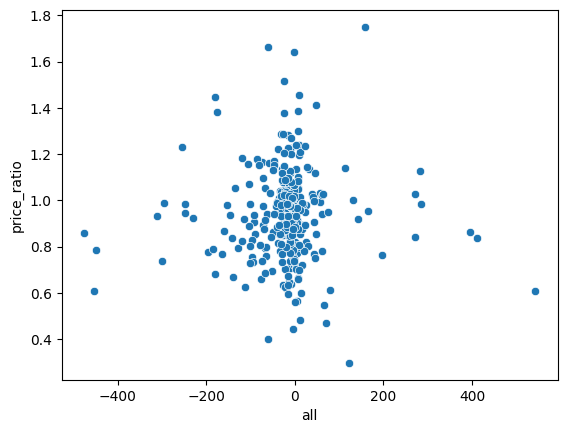

In [53]:
sns.scatterplot(full_data_compare.loc[full_data_compare['all']> -500], x = 'all', y = 'price_ratio')
plt.show()